In [140]:
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torch.optim as optimizer
import torch.nn.functional as F

import numpy as np

In [141]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

1x1 Convolutions

In [142]:
def conv1(in_dim, out_dim):
  model = nn.Sequential(
      nn.Conv2d(in_dim, out_dim, 1, 1),
      nn.ReLU()
  )
  return model

1x1 Convolutions -> 5x5 Convolutions



In [143]:
def conv1_5(in_dim, mid_dim, out_dim):
  model = nn.Sequential(
      nn.Conv2d(in_dim, mid_dim, 1, 1),
      nn.ReLU(),
      nn.Conv2d(mid_dim, out_dim,5, 1, 2),
      nn.ReLU()
  )
  return model

1x1 Convolutions -> 3x3 Convolutions

In [144]:
def conv1_3(in_dim, mid_dim, out_dim):
  model = nn.Sequential(
      nn.Conv2d(in_dim, mid_dim, 1, 1),
      nn.ReLU(),
      nn.Conv2d(mid_dim, out_dim,3, 1, 1),
      nn.ReLU()
  )
  return model

 3x3 MaxPooling -> 1x1 Convolutions

In [145]:
def max3_1(in_dim, out_dim):
  model = nn.Sequential(
      nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
      nn.Conv2d(in_dim, out_dim, 1, 1),
      nn.ReLU()
  )
  return model

Inception Module

In [146]:
class Inception_Module(nn.Module):
  def __init__(self, in_dim, out_dim_1, mid_dim_3, out_dim_3, mid_dim_5, out_dim_5, pool_dim):
    super(Inception_Module, self).__init__()

    self.conv_1 = conv1(in_dim, out_dim_1)

    self.conv_1_3 = conv1_3(in_dim, mid_dim_3, out_dim_3)

    self.conv_1_5 = conv1_5(in_dim, mid_dim_5, out_dim_5)

    self.max_3_1 = max3_1(in_dim, pool_dim)

  def forward(self, x):
    out_1 = self.conv_1(x)
    out_2 = self.conv_1_3(x)
    out_3 = self.conv_1_5(x)
    out_4 = self.max_3_1(x)

    output = torch.cat([out_1, out_2, out_3, out_4], 1)
    return output

In [147]:
import torchsummary

a = Inception_Module(192,64,96,128,16,32,32)
torchsummary.summary(a, input_size=(192, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]          12,352
              ReLU-2           [-1, 64, 28, 28]               0
            Conv2d-3           [-1, 96, 28, 28]          18,528
              ReLU-4           [-1, 96, 28, 28]               0
            Conv2d-5          [-1, 128, 28, 28]         110,720
              ReLU-6          [-1, 128, 28, 28]               0
            Conv2d-7           [-1, 16, 28, 28]           3,088
              ReLU-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 32, 28, 28]          12,832
             ReLU-10           [-1, 32, 28, 28]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 32, 28, 28]           6,176
             ReLU-13           [-1, 32, 28, 28]               0
Total params: 163,696
Trainable params:

AuxModule Implementation

In [148]:
class AuxModule(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(AuxModule, self).__init__()

        self.avgpool = nn.AvgPool2d(5, 3)
        self.conv1 = nn.Conv2d(in_channels, 128, kernel_size=1, stride=1)
        self.fc = nn.Sequential(
            nn.Linear(4*4*128, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.7),
            nn.Linear(1024, num_classes),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv1(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

GoogLeNet Implementation with Inception Module

In [149]:
learning_rate = 0.0002
num_epoch = 2

In [150]:
class GoogLeNet(nn.Module):
  def __init__(self, base_dim=64, num_classes=10):
    super(GoogLeNet, self).__init__()
    self.num_classes = num_classes

    self.layer_1 = nn.Sequential(
        nn.Conv2d(3, base_dim, 7, 2, 3),
        nn.MaxPool2d(3, 2, 1),
        nn.LocalResponseNorm(2),
        nn.Conv2d(base_dim, base_dim*3, 3, 1, 1),
        nn.MaxPool2d(3, 2, 1)
        )

    self.layer_2 = nn.Sequential(
        Inception_Module(base_dim*3, 64, 96, 128, 16, 32, 32),
        Inception_Module(base_dim*4, 128, 128, 192, 32, 96, 64),
        nn.MaxPool2d(3, 2, 1)
    )

    self.inception_4a = Inception_Module(480, 192, 96, 208, 16, 48, 64)
    self.aux1 = AuxModule(512, num_classes)

    self.layer_3 = nn.Sequential(
        Inception_Module(base_dim*8, 160, 112, 224, 24, 64, 64),
        Inception_Module(base_dim*8, 128, 128, 256, 24, 64, 64)
    )

    self.inception_4d = Inception_Module(base_dim*8, 112, 144, 288, 32, 64, 64)
    self.aux2 = AuxModule(528, num_classes)

    self.layer_4 = nn.Sequential(
        Inception_Module(528, 256, 160, 320, 32, 128, 128),
        nn.MaxPool2d(3, 2, 1),
        Inception_Module(832, 256, 160, 320, 32, 128, 128),
        Inception_Module(832, 384, 192, 384, 48, 128, 128),
        nn.AvgPool2d(7, 1)
    )

    self.layer_5 = nn.Dropout2d(0.4)
    self.layer_6 = nn.Linear(1024, 10)


  def forward(self, x):
    out = self.layer_1(x)
    out = self.layer_2(out)
    out = self.inception_4a(out)
    if self.training:
      out1 = self.aux1(out)
    out = self.layer_3(out)
    out = self.inception_4d(out)
    if self.training:
      out2 = self.aux2(out)
    out = self.layer_4(out)
    out = self.layer_5(out)
    out = out.view(-1, 1024)
    out = self.layer_6(out)

    if self.training:
      return [out, out1, out2]

    else:
      return out

In [151]:
import torchsummary

a = GoogLeNet()
torchsummary.summary(a, input_size=(3, 224, 224),batch_size=64, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 112, 112]           9,472
         MaxPool2d-2           [64, 64, 56, 56]               0
 LocalResponseNorm-3           [64, 64, 56, 56]               0
            Conv2d-4          [64, 192, 56, 56]         110,784
         MaxPool2d-5          [64, 192, 28, 28]               0
            Conv2d-6           [64, 64, 28, 28]          12,352
              ReLU-7           [64, 64, 28, 28]               0
            Conv2d-8           [64, 96, 28, 28]          18,528
              ReLU-9           [64, 96, 28, 28]               0
           Conv2d-10          [64, 128, 28, 28]         110,720
             ReLU-11          [64, 128, 28, 28]               0
           Conv2d-12           [64, 16, 28, 28]           3,088
             ReLU-13           [64, 16, 28, 28]               0
           Conv2d-14           [64, 32,

In [152]:
a

GoogLeNet(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): Inception_Module(
      (conv_1): Sequential(
        (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
      (conv_1_3): Sequential(
        (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
      (conv_1_5): Sequential(
        (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(

In [153]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar10_train = datasets.CIFAR10(root="../Data/", train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(cifar10_train, batch_size=64,shuffle=True, num_workers=2)


cifar10_test = datasets.CIFAR10(root="../Data/", train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(cifar10_test, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

images, labels = next(iter(trainloader))

print(images.size(), labels.size())

Files already downloaded and verified
Files already downloaded and verified
torch.Size([64, 3, 224, 224]) torch.Size([64])


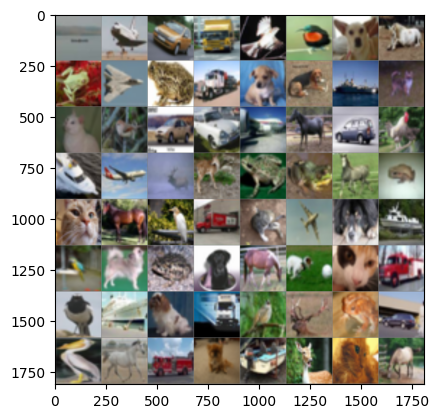

In [154]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


images, labels = next(iter(trainloader))

imshow(torchvision.utils.make_grid(images))


In [155]:
model = GoogLeNet().to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

모델 용량이 너무 커서 코랩으로는 무리...
Epoch 단 두 번만 돌려봄

In [156]:
loss_arr = []
for i in range(num_epoch):
    for j,[image,label] in enumerate(trainloader):
        x = image.to(device)
        y= label.to(device)

        optimizer.zero_grad()
        pred1, pred2, pred3 = model.forward(x)
        loss1 = loss_func(pred1,y)
        loss2 = loss_func(pred2, y)
        loss3 = loss_func(pred3, y)

        # loss1과 loss3에 0.3을 곱하는 것은 최종 output보다 영향력 다운시키기 위해
        loss = loss1 + loss2 * 0.3 + loss3 * 0.3

        loss.backward()
        optimizer.step()


    if i % 10 ==0:
        print(loss)
        loss_arr.append(loss.cpu().detach().numpy())

tensor(2.9600, device='cuda:0', grad_fn=<AddBackward0>)
